In [23]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [24]:
beta0 = 2.
beta1 = 1.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=-2,scale=1,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([497]))


In [25]:
np.random.seed()
yn,xn,nobs = gen_data()

In [26]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,cc=False,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        self.cc = cc
        self.ols = ols
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        pr_m = np.log(max(m.mean(),1e-4))
        
        if not self.cc:
            pr_m = stats.norm.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))

        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
    


model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Tobit Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -973.22
Model:                          Tobit   AIC:                             1950.
Method:            Maximum Likelihood   BIC:                             1960.
Date:                Tue, 24 Nov 2020                                         
Time:                        18:34:12                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9310      0.075     25.678      0.000       1.784       2.078
x1             0.9491      0.041     23.232      0.000       0.869       1.029
var            0.9760      0.065     15.020      0.000       0.849       1.103
==============================================================================
"""

In [27]:
model3 = sm.OLS(yn,sm.add_constant(xn))
model3_fit = model3.fit()
print(model3_fit.summary())

model3 =  Tobit(yn,sm.add_constant(xn),ols=True)
model3_fit = model3.fit(disp=False)
print(model3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     634.4
Date:                Tue, 24 Nov 2020   Prob (F-statistic):          9.33e-109
Time:                        18:34:12   Log-Likelihood:                -998.46
No. Observations:                1000   AIC:                             2001.
Df Residuals:                     998   BIC:                             2011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5857      0.045     35.207      0.0

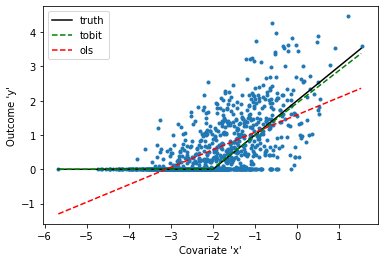

In [28]:
#create plot for true
plt.scatter(xn,yn,marker='.')
support_x = np.arange(xn.min(),xn.max(),.05)

#truth
plt.plot(support_x, np.maximum(beta0+beta1*support_x,0) ,label="truth",
         color='black')

#tobit
plt.plot(support_x, np.maximum(0,model1_fit.params[0] + model1_fit.params[1]*support_x) ,label="tobit",
         color='green',linestyle='--')

#ols
plt.plot(support_x, model3_fit.params[0] + model3_fit.params[1]*support_x ,label="ols",
         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome 'y'")
plt.xlabel("Covariate 'x'")
plt.savefig('../figs/tobit_plot1.png')
plt.legend()
plt.show()


In [29]:
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).min() )

25.236903141901173
0.42582705909310065
5.620541818614786
-1.9193525057298093


In [30]:
y_cens, x_cens = yn[yn!=0],xn[yn!=0]
model2 = sm.OLS(y_cens,sm.add_constant(x_cens))
model2_fit = model2.fit()
print(model2_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),cc=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     230.6
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           3.18e-43
Time:                        18:34:20   Log-Likelihood:                -556.79
No. Observations:                 511   AIC:                             1118.
Df Residuals:                     509   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9104      0.060     31.697      0.0

In [31]:
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).min() )

-66.60003441543198
0.3596078573964828
2.319293284144962
-2.6740469589340177
